In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive/')

# 目的の場所（フォルダ・ディレクトリ）へ移動（各自の環境で適宜修正）
%cd "/content/drive/MyDrive/Colab Notebooks/JKJ1A/"
%ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/JKJ1A
backyard/  data/  model/  notebook/  src_day1/  src_day1_ans/


---
# 概要
ここの内容は[Pytorch公式のチュートリアル](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)に一部基づいています．

---
# 1. データセット準備
画像データセットCIFAR10をダウンロードし前処理を行います．

In [ ]:
# モジュールのインポート
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader, Subset

import warnings
warnings.filterwarnings("ignore")  # warningを表示しない

In [ ]:
np.isin(trainset.targets, classes)[:15]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
indices = np.where(np.isin(trainset.targets, classes))
indices

(array([], dtype=int64),)

In [ ]:
classes_id = [trainset.class_to_idx[c] for c in classes]
classes_id

[2, 3, 4, 7, 9]

In [ ]:
np.where(np.isin([1,2,3,4], classes_id))[0]

array([1, 2, 3])

In [ ]:
# データロード関数を定義
## 引数batch_sizeはミニバッチの大きさ

def load_data(batch_size, n_train=15000, n_test=2500):

    # クラスのラベル名
    classes = ('bird', 'cat', 'deer', 'horse', 'truck')
    # 本当は10クラスあるが，今回は学習時間短縮のため一部に絞る．
    # classes = ('airplane', 'automobile', 'bird', 'cat',
    #         'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    ## 前処理関数の準備
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

    # CIFAR10の準備（ローカルにデータがない場合はダウンロードされる）
    # 訓練用データセット
    trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    # 評価用データセット
    testset = CIFAR10(root='./data', train=False, download=True, transform=transform)


    # --- 学習時間短縮のためデータを選別（本質的でないので気にしなくていい）-------------
    trainset.targets = np.asarray(trainset.targets)
    testset.targets = np.asarray(testset.targets)

    classes_id = [trainset.class_to_idx[c] for c in classes]             # クラス名を数値（クラスid）に

    indices = np.where(np.isin(trainset.targets, classes_id))            # 該当クラスの位置
    trainset.data = trainset.data[indices]                               # 該当クラスのデータを抽出
    trainset.targets = trainset.targets[indices]                         # 該当クラスのラベルを抽出
    trainset.targets = [classes_id.index(i) for i in trainset.targets]   # クラスidを0からの連番に  
    
    indices = np.where(np.isin(testset.targets, classes_id))
    testset.data = testset.data[indices]
    testset.targets = testset.targets[indices]
    testset.targets = [classes_id.index(i) for i in testset.targets]

    # trainsetの内，n_train個だけ選ぶ
    trainset, _ = random_split(trainset, [n_train, len(trainset) - n_train])
    # testsetの内，n_test個だけ選ぶ
    testset, _ = random_split(testset, [n_test, len(testset) - n_test])
    # ------------------------------------------------------------------------


    # !ミニバッチに小分けしておく．これを後で使う
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    # !ミニバッチに小分けしておく．これを後で使う
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return (trainloader, testloader, classes)

In [ ]:
# 関数を実行
trainloader, testloader, classes = load_data(4)

Files already downloaded and verified
Files already downloaded and verified


### Dataloaderの中身
上で，訓練用データと評価用データはそれぞれtrainloaderとtestloaderというDataloaderの形で準備されれた．Dataloaderはイメージとしては，[ミニバッチ1, ミニバッチ2, ...]というようにミニバッチごとに分割されている．

In [ ]:
# trainloaderからミニバッチを一つ取り出す
dataiter = iter(trainloader)
images, labels = dataiter.next()  # ミニバッチを一つ取り出す

'''
今回はバッチサイズ4 (batch_size = 4）なので，
imagesには4枚の画像，labelsには対応する4つのラベルが入っている
'''
print("images.shape = {}".format(images.shape))  # -> torch.Size([4, 3, 32, 32])
print("labels.shape = {}".format(labels.shape))  # -> torch.Size([4])

'''
画像一枚は，3 x 32 x 32の3次元テンソル
ラベル1つは，サイズ1の1次元テンソル
'''
print(images[0])  # -> (...)
print(labels[0])  # -> torch.Size(0)

images.shape = torch.Size([4, 3, 32, 32])
labels.shape = torch.Size([4])
tensor([[[ 0.8118,  0.8196,  0.7882,  ...,  0.7804,  0.7647,  0.7412],
         [ 0.8902,  0.8745,  0.8588,  ...,  0.7412,  0.7490,  0.7412],
         [ 0.8196,  0.7804,  0.8196,  ...,  0.7490,  0.7412,  0.7333],
         ...,
         [ 0.2549,  0.2471,  0.2627,  ...,  0.3569,  0.3412,  0.3333],
         [ 0.3333,  0.3725,  0.3882,  ...,  0.3098,  0.3255,  0.3333],
         [ 0.3961,  0.4745,  0.5137,  ...,  0.3176,  0.3490,  0.3804]],

        [[ 0.9373,  0.9373,  0.9294,  ...,  0.9843,  0.9922,  0.9765],
         [ 0.9765,  0.9765,  0.9765,  ...,  0.9608,  0.9843,  0.9765],
         [ 0.9451,  0.9294,  0.9765,  ...,  0.9686,  0.9765,  0.9765],
         ...,
         [ 0.4667,  0.4431,  0.4431,  ...,  0.5294,  0.5137,  0.4980],
         [ 0.4667,  0.4667,  0.4510,  ...,  0.4824,  0.4902,  0.4980],
         [ 0.4667,  0.5059,  0.5137,  ...,  0.4824,  0.5059,  0.5451]],

        [[ 0.9765,  0.9529,  0.9451,  ..., 

### 画像の表示

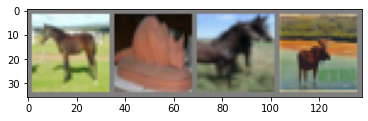

horse   cat horse  deer


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# !!画像を表示するための関数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルのプリント
print(' '.join('%5s' % classes[labels[j]] for j in range(images.shape[0])))

---
# 2. モデルの定義
学習させるニューラルネットワークのモデルを定義します．

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## !!ネットワークのクラス．今後各自モデルを修正するはず
class Net(nn.Module):
    # 初期化の時にレイヤーが準備される部分
    def __init__(self):   
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)          # 畳み込み層
        self.pool = nn.MaxPool2d(2, 2)           # プーリング層
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)    # 全結合層   
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # ネットワークにデータを通す時に機能する
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     # 畳み込み -> 活性化 -> プーリング
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)               # テンソルの形を成形
        x = F.relu(self.fc1(x))                  # 全結合 -> 活性化
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**実際に具体的なモデルを生成**

In [ ]:
net = Net()   # __init__(self)の部分が実行される

**モデルにデータを代入する**

In [ ]:
it = iter(trainloader)
images, labels = it.next()  # ミニバッチを一つ取り出す

output = net(images)  # forward(self, x)の部分が実行される（net(x)の代わりにnet.forward(x)でもOK）
                      # ミニバッチの画像4枚をまとめて代入している
                      # ネットワークの出力は10次元ベクタ（を画像4枚分）

'''
具体的には以下のような 画像の枚数（4）x ネットワークの出力次元（10）
output = [[-0.03, 0.08, ..., 0.06], 
          [-0.04, 0.06, ..., 0.03], 
          [-0.03, 0.10, ..., 0.02], 
          [-0.01, 0.09, ..., 0.04]]
 - 画像の枚数が4なのはbatch_size = 4と設定したから．
 - ネットワークの出力次元が10なのは，今回は10クラスの分類問題だから．
'''
print(f'output.shape = {output.shape}')  # -> torch.Size([4, 10])

output.shape = torch.Size([4, 10])


**分類結果を見てみる**


In [ ]:
'''
          ----> dim=1
output = :     [[-0.03, 0.08, ..., 0.06], 
         v    　[-0.04, 0.06, ..., 0.03], 
        dim0    [-0.03, 0.10, ..., 0.02], 
                [-0.01, 0.09, ..., 0.04]]
 - 各画像のネットワークの出力（10次元）のうち，「最大の値がある位置」が，ネットワークによる予測のラベル．
 - 「最大の値」は `max()` という関数で見つけられる．「最大の値がある位置」は `argmax()`という関数で見つけられる．
 - 特に今回は横方向（dim=1の方向）で最大を見たいので，`argmax(dim=-1)`という関数を使う．
'''
pred_labels = output.argmax(dim=1)  # これは4次元ベクトル

'''
またネットワークを学習させていないので，正解のラベルと全く合っていないことが見て取れる
'''
     
print(f'predicted labels: {pred_labels}')
print(f'true labels     : {labels}')

predicted labels: tensor([8, 8, 8, 8])
true labels     : tensor([1, 0, 2, 4])


---
# 3. 学習
準備したデータセットでモデルを学習します．

### 訓練

In [ ]:
# !!訓練関数を定義（下の方でGPUを使った拡張版があります．実験では基本的にそっちを使う）
def train_cpu(net, trainloader, optimizer, criterion, nepochs=2):
    net.train()  # ネットワークを「訓練モード」にする（おまじない）．
    
    for epoch in range(nepochs):  
        running_loss = 0.0
        for data in trainloader:  # ミニバッチを一つずつ処理していく
            images, labels = data

            # オプティマイザの初期化
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)              # ネットワークへの代入
            loss = criterion(outputs, labels)  # ロスの計算 
            loss.backward()                    # 勾配の計算
            optimizer.step()                   # ネットワークパラメタの更新

            running_loss += loss.item()

        running_loss = running_loss / len(trainloader)
        print(f'[epoch {epoch + 1:2d}] loss: {running_loss:.3f}')

    print('Training completed')


In [ ]:
%%time
# 上のマジックコマンドで時間を計測できる -> Wall time: 39.3 sec

import torch.optim as optim

net = Net()  # ネットワークの初期化

# オプティマイザ定義（確率的勾配法SGD）
'optimizerの引数に，最適化すべきパラメタnet.parameters()が渡されている事に注目'
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# ロス関数の定義：分類で標準的なクロスエントロピーロス
criterion = nn.CrossEntropyLoss()  

# ネットワークの訓練
# 引数：ネットワーク，訓練データ，オプティマイザ，ロス関数，エポック数
train_cpu(net, trainloader, optimizer, criterion, nepochs=2)

# 学習が終わったら評価モードにする．
net.eval() 

[epoch  1] loss: 1.374
[epoch  2] loss: 1.099
Training completed
CPU times: user 31.5 s, sys: 2.98 s, total: 34.4 s
Wall time: 39.3 s


### 学習したモデルの保存

In [ ]:
PATH = 'model/model_cifar10_cpu.pth'
torch.save(net.state_dict(), PATH)

%mkdir model/ # modelディレクトリの作成
%ls model/    # modelディレクトリの中を表示

# 読み込むときは
# net = Net()                          # 空のネットワークを準備
# state_dict = torch.load(PATH)        # 保存したパラメタをロード
# net.load_state_dict(state_dict)      # ネットワークにパラメタをセット

---
# 4. モデルの評価
学習したモデルの性能を評価します．

### 練習問題（10分）: 学習したモデルを評価してみよう
学習したモデルの正解率を計算する関数test(...)を定義して，訓練データ，テストデータそれぞれでの正解率を出してみましょう．

In [ ]:
def test_cpu(net, dataloader):
    net.eval()  # ネットワークを「評価モード」にする（おまじない）．

    # ここを埋める．これ以前のコードを参考にすると良い


    return acc  # 正解率を返す



In [ ]:
%%time

# 訓練データでの正解率（時間がかかるので，まずテストデータだけ使ってtest(...)がうまく機能するか確認する）
# train_acc = test(net, trainloader)  
# print(f'train acc = {train_acc}')

# テストデータでの正解率
test_acc = test_cpu(net, testloader)   
print(f' test acc = {test_acc}')

### 練習問題（解答例）：授業で指示があるまで見ないこと．

In [ ]:
# !!テスト関数（下の方でGPUを使った拡張版があります．実験では基本的にそっちを使う）
def test_cpu(net, dataloader):
    net.eval()  # ネットワークを「評価モード」にする（おまじない）．

    correct = 0  # 正解数
    total = 0    # 画像総数

    for data in dataloader:
        images, labels = data

        outputs = net(images)
        predicted = outputs.argmax(dim=1)  # !各画像に関して最大値のインデックスを取り出す
        
        correct += (predicted == labels).sum().item()  # `a += b` は `a = a + b`の意味
        total += len(labels)

    acc = correct / total

    return acc 

In [ ]:
%%time 
train_acc = test_cpu(net, trainloader)
test_acc = test_cpu(net, testloader)
print(f'train acc = {train_acc:.3f}')  # ':.3f'とつけると小数点以下3桁までの表示になる
print(f' test acc = {test_acc:.3f}')

train acc = 0.497
 test acc = 0.487
CPU times: user 13.6 s, sys: 2.07 s, total: 15.6 s
Wall time: 20.4 s


---
# 5. GPUを使う
GPUを使うことで計算を高速化できます．ただし少しややこしい部分があり，エラーを出す原因になるのでここでまとめます．

**Step 1: このノートブックのRuntime設定を変える**

1. 上のタブのRuntimeを選択
2. Change runtime typeを選択
3. Hardware accelaratorの部分でGPUを選択

**Step 2: 今まで関数を定義したセルを再実行**
- Runtime設定を変えるとノートブックの記憶が初期化されるので，一番上のセルから必要に応じて全て再実行する必要がある．Google Driveのマウント（一番上のセル），から，全てのセルを再実行せよ．

**Step 3: コードを修正する**

- **大原則として，「全てGPUに移す」ことが重要．**
- 画像も，ラベルも，モデルも，全て同じところ（GPU or CPU）にないと，エラーが出る．

#### 訓練（GPU使用版）
**ネットワーク，画像，ラベルが.cuda()でGPUに移動されていることに注目**

In [ ]:
# !!訓練関数を定義
def train(net, trainloader, optimizer, criterion, nepochs=2):
    net.train()  # ネットワークを「訓練モード」にする（おまじない）．

    for epoch in range(nepochs):  
        running_loss = 0.0
        for data in trainloader:  # ミニバッチを一つずつ処理していく
            images, labels = data
            images, labels = images.cuda(), labels.cuda() # *** 画像とラベルをGPUに移す（代入が必要） ***

            # オプティマイザの初期化
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)              # ネットワークへの代入
            loss = criterion(outputs, labels)  # ロスの計算 
            loss.backward()                    # 勾配の計算
            optimizer.step()                   # ネットワークパラメタの更新

            running_loss += loss.item()

        running_loss = running_loss / len(trainloader)
        print(f'[epoch {epoch + 1:2d}] loss: {running_loss:.3f}')

    print('Training completed')

In [ ]:
%%time
net = Net()  # ネットワークの初期化
net.cuda()  # *** ネットワークをGPUに移す ***
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 確率的勾配法SGD
train(net, trainloader, optimizer, criterion, nepochs=2)
net.eval()

### 練習問題（3分）：GPUを活かそう

せっかくGPUを使ったのに遅いのはなぜだろうか？それは今回 `batch_size = 4`で画像を少しずつで処理しているため，GPUを活かせていないからである．`batch_size=128`でcpu版の訓練と，GPU版の訓練の速度を比較してみよ．

In [ ]:
## trainloaderのbatch_sizeを128にする


In [ ]:
%%time

## cpuで訓練する


In [ ]:
%%time

## gpuで訓練する


### 練習問題（解答例）：授業で指示があるまで見ないこと．

In [ ]:
trainloader, testloader, classes = load_data(128)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
%%time
net = Net()  # ネットワークの初期化
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 確率的勾配法SGD
train_cpu(net, trainloader, optimizer, criterion, nepochs=2)

[epoch  1] loss: 2.305
[epoch  2] loss: 2.305
Training completed
CPU times: user 22.1 s, sys: 899 ms, total: 23 s
Wall time: 26 s


In [ ]:
%%time
net = Net()  # ネットワークの初期化
net.cuda()  # *** ネットワークをGPUに移す ***
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 確率的勾配法SGD
train(net, trainloader, optimizer, criterion, nepochs=2)

[epoch  1] loss: 2.305
[epoch  2] loss: 2.305
Training completed
CPU times: user 3.53 s, sys: 590 ms, total: 4.12 s
Wall time: 16.5 s


## よくあるGPU関係のエラー

モデルとデータが別の場所にある

In [ ]:
# netはGPU，imagesはCPUにある
net.cuda()
images = images.cpu()  # 解決：images.cuda()とする
                       # 別解：net.cpu()とする
net(images)

RuntimeError: ignored

新しいテンソルをGPUに移し忘れる

In [ ]:
net.cuda()                          # ネットワークをgpuへ
images = images.cuda()              # 画像をgpuへ
noise = torch.randn(*images.shape)  # imagesと同じ形のランダムノイズテンソル

net(images + noise)      # noiseはcpuにある！！！
                         # 解決：noise = noise.cuda()としておく
                         # 別解：noise = torch.randn_like(images) （imagesと同じサイズで同じデバイス[cpu or gpu]に作ってくれる）

RuntimeError: ignored

matplotlibでplotをする時にcpuに戻していない

TypeError: ignored

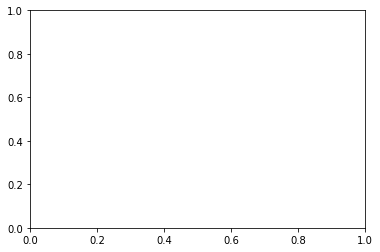

In [ ]:
itr = iter(trainloader)
images, labels = itr.next()
images = images[:4]  # 最初の4枚だけ取り出す
outputs = net(images.cuda())

for output in outputs:  # それぞれの画像の出力をプロット（縦軸値，横軸10次元）
    plt.plot(range(10), output)  # 解決：事前に output = output.detach().cpu()とする．GPUにあるものをCPUに戻すときにおまじないと考えてほしい
plt.show()

---
# 6. `.py`ファイルで学習

今使っているセルごとに実行している形式はJupyter notebookと呼ばれます．これは便利ですが，コードが長くなると，たくさんのセルに散らばるし，いちいち全てを実行するのも面倒になります．全ての内容をひとまとめにしたPythonファイル `train_cifar10.py`を作ると，次のように実行できてとても便利です．


In [ ]:
!python src/train_cifar10.py --nepochs 2 --batch_size 128 --lr 0.01 --save_model_name 'model/model_cifar10_lenet.pth'

上に書いてあるのを説明します．
- `!python src/train_cifar10.py`で，`src`ディレクトリにある`train_cifar10.py`を実行します．
- `--nepochs 2`などで訓練パラメータを指定しています．
- `--save-model-name 'model/model_cifar10_day1.pth'`で，`model`ディレクトリに`model_cifar10_day1.pth`という名前でモデルを保存しています．